# God Components project Statistics
## Loading datasets
Import dependencies.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from src.git_utils import get_commits, compute_locs, git_checkout, get_locs

Load commit data.

In [2]:
all_commits = get_commits()
all_commits.head()

commit       author                email  \
0  5ad435d39e39558b98af3af5aca291eef22651f0     tallison  tallison@apache.org   
1  e8b4305ce80df59e45352e73ceb972f4534c984c     tallison  tallison@apache.org   
2  b0fb00ef6a11db121c56436b9542a4cf248fef8b  Tim Allison  tallison@apache.org   
3  566c5962101db0be4ff56c6ff3740c05701a3c0e    THausherr      tilman@snafu.de   
4  d732cc17ea555572d1b1fe9e041931fb36567cdf     tallison  tallison@apache.org   

                    datetime  \
0  2021-01-12 15:10:23-05:00   
1  2021-01-11 17:05:01-05:00   
2  2021-01-11 15:48:10-05:00   
3  2021-01-10 14:21:20+01:00   
4  2021-01-07 16:45:31-05:00   

                                             message       jira  
0   TIKA-3267 change boolean getXYZ to boolean isXYZ  TIKA-3267  
1               TIKA-3269 update artifacts for 2.0.0  TIKA-3269  
2                                   TIKA-3266 (#396)  TIKA-3266  
3                             TIKA-3244: update zstd  TIKA-3244  
4  TIKA-3268 -- throw exception if excluded parse...  TIKA-3268

Load the aggregated report file, `all_reports.csv`. Contains Designite report data for every single Tika commit.

In [122]:
all_reports = pd.read_csv('output/all_reports.csv', dtype={'package': 'category'})
all_reports = all_reports.rename(columns={'metric': '# classes'}) # rename col
all_reports.head()

commit         repo  \
0  49bb4691393c016d8d65e6b11febca9e56feedef  tika-cpu_21   
1  49bb4691393c016d8d65e6b11febca9e56feedef  tika-cpu_21   
2  49bb4691393c016d8d65e6b11febca9e56feedef  tika-cpu_21   
3  49bb4691393c016d8d65e6b11febca9e56feedef  tika-cpu_21   
4  49bb4691393c016d8d65e6b11febca9e56feedef  tika-cpu_21   

                   package          smell         cause  # classes  
0  org.apache.tika.example  God Component  MANY_CLASSES         49  
1    org.apache.tika.batch  God Component  MANY_CLASSES         31  
2   org.apache.tika.detect  God Component  MANY_CLASSES         31  
3   org.apache.tika.parser  God Component  MANY_CLASSES         37  
4     org.apache.tika.mime  God Component  MANY_CLASSES         31

Load up Tika's Jira issue tracking issues.

In [291]:
all_issues = pd.read_csv('output/all_issues.csv', dtype={'issuetype': 'category'})
all_issues = all_issues.drop(columns=['id', 'self', 'reporter', 'updated'])
all_issues.head()

jira resolution priority assignee    status          creator  \
0  TIKA-3256      Fixed    Minor   tilman  Resolved           tilman   
1  TIKA-3255        NaN    Major      NaN      Open  peterkronenberg   
2  TIKA-3254        NaN    Major      NaN      Open           sathia   
3  TIKA-3253        NaN    Minor      NaN      Open           tilman   
4  TIKA-3252        NaN  Trivial      NaN      Open           tilman   

     issuetype                resolutiondate                       created  \
0         Task  2020-12-27T13:08:45.000+0000  2020-12-27T13:07:15.000+0000   
1          Bug                           NaN  2020-12-22T17:04:55.000+0000   
2          Bug                           NaN  2020-12-22T13:49:17.000+0000   
3  Improvement                           NaN  2020-12-17T08:57:18.000+0000   
4          Bug                           NaN  2020-12-17T08:38:45.000+0000   

      components  
0        general  
1            NaN  
2            NaN  
3      tika-eval  
4  documentation

Load up data on Lines Of Code for every God Component at the state of every commit.

In [5]:
all_locs = get_locs()
all_locs.head()

additions  deletions                                    commit  change  \
0       6638          0  fe4cd58cced0e15f1848afbc2518ab4a66e6867f    6638   
1        251        227  dbc5eb76b7a21587eba83724e36bff1cb29e72c6      24   
2         13         14  8054dddc156444a0e67a66fcd2dbc9b4bb5db4b7      -1   
3         28         26  4ae33b70378e0ee66b7d9c95d6fd7d51b10cc658       2   
4        353        334  6a013f550bf7e8cfbed4652ec3785e1627d0f7ea      19   

    LOC  
0  6638  
1  6662  
2  6661  
3  6663  
4  6682

## Combine datasets

In [292]:
# keep only necessary columns
all_reports = all_reports[['commit', 'package', '# classes']]
all_issues = all_issues[['jira', 'issuetype']]
all_locs = all_locs[['commit', 'LOC', 'change']]

gcdata = all_commits\
    .merge(all_reports, on='commit')
locdata = gcdata\
    .merge(all_locs, on='commit')
issuedata = gcdata\
    .merge(all_issues, on='jira')
gcdata.shape, locdata.shape, issuedata.shape

((28077, 8), (26744, 10), (17726, 9))

## God component lifetime
General statistics on lifetime.

In [49]:
# Compute date data
dt = gcdata.groupby('package')['datetime']
normalize_date = lambda date: pd.to_datetime(date, utc=True)\
                    .dt.tz_convert('Europe/Amsterdam')
dtmin = normalize_date(dt.min())
dtmax = normalize_date(dt.max())
became_gc   = dtmin.dt.strftime('%Y-%m-%d')
last_gc     = dtmax.dt.strftime('%Y-%m-%d')
gc_commits  = dt.count()
gc_days     = (dtmax - dtmin).dt.days

# Compute author data
authors = gcdata.groupby('package')['author'].unique()
n_authors = authors.transform(lambda x: len(x))

# DataFrame
stats = pd.DataFrame([became_gc, last_gc, gc_commits, gc_days, n_authors],
        ['Became GC at', 'Last seen as GC', '# GC commits', '# GC days', '# authors'])\
        .transpose().reset_index()
stats

package Became GC at Last seen as GC  \
0                      org.apache.tika.batch   2015-06-28      2020-12-14   
1                     org.apache.tika.detect   2017-01-19      2020-12-14   
2                    org.apache.tika.example   2015-05-04      2020-12-14   
3                       org.apache.tika.fork   2018-05-31      2020-12-14   
4                   org.apache.tika.metadata   2016-09-26      2020-12-14   
5                       org.apache.tika.mime   2015-05-02      2020-12-14   
6                     org.apache.tika.parser   2015-02-21      2020-12-14   
7           org.apache.tika.parser.microsoft   2011-11-25      2020-12-14   
8       org.apache.tika.parser.microsoft.chm   2020-08-21      2020-12-14   
9   org.apache.tika.parser.microsoft.onenote   2019-12-16      2020-12-14   
10    org.apache.tika.parser.microsoft.ooxml   2017-03-23      2020-12-14   
11                org.apache.tika.parser.txt   2009-05-22      2020-12-14   
12                       org.apache.tika.sax   2011-09-25      2020-12-14   
13                    org.apache.tika.server   2014-05-07      2020-12-14   
14                     org.apache.tika.utils   2020-10-31      2020-12-14   

   # GC commits # GC days # authors  
0          2352      1996       114  
1          1579      1424        82  
2          2433      2050       115  
3           738       927        52  
4          1743      1539        88  
5          2443      2053       115  
6          2429      2123       116  
7          3052      3306       121  
8           155       114        14  
9           305       363        26  
10         1454      1361        80  
11         4539      4223       123  
12         3691      3367       121  
13         1078      2412        47  
14           86        44         8

In [50]:
'Average GC lifetime: ' + str(gc_days.mean() / 365) + ' years'

'Average GC lifetime: 4.986666666666667 years'

Average over the above stats

In [51]:
stats.agg({
    '# GC commits': 'mean',
    '# GC days': 'mean',
    '# authors': 'mean'
})

# GC commits    1871.800000
# GC days       1820.133333
# authors         81.466667
dtype: float64

Total amount of God Components

Text(0, 0.5, '# god components')

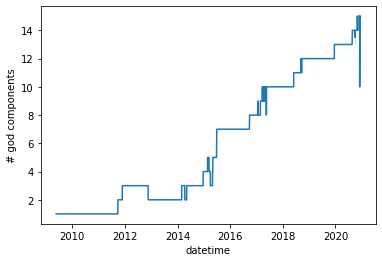

In [54]:
total_gcs = gcdata.groupby(['commit', 'datetime']).count().reset_index()
sns.lineplot(data=total_gcs, x='datetime', y='# classes')
plt.ylabel('# god components')

Amount of classes per God Component

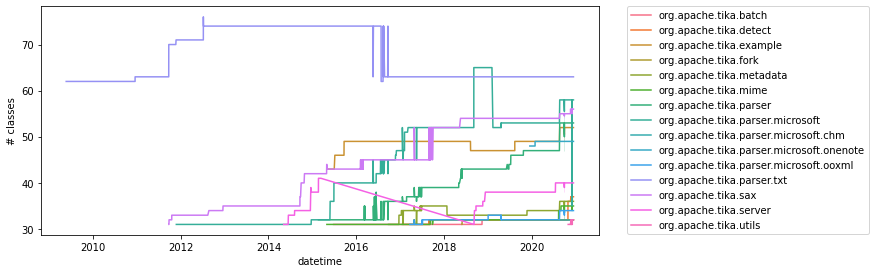

In [58]:
fig, ax = plt.subplots(figsize=(10, 4.2))
g = sns.lineplot(data=gcdata.sort_values('package'),
    x='datetime', y='# classes', hue='package', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Computing the `# classes` chronological difference (delta)

In [549]:
gcdelta = all_reports.groupby('package')\
    .apply(lambda df: df.merge(all_commits, on='commit', how='right').drop(columns=['package']))
gcdelta['is gc'] = gcdelta['# classes'] > 0
gcdelta['is gc diff'] = gcdelta['is gc'].diff(periods=-1)
gcdelta['is gc diff'][gcdelta['is gc diff'].isna()] = False
gcdelta['# classes diff'] = gcdelta['# classes'].diff(periods=-1)
gcdelta['# classes diff'][gcdelta['# classes diff'].isna()] = 0.0
gcdelta['# classes diff'] = gcdelta['# classes diff'].astype(int)
gcdelta = gcdelta.reset_index(level=0)
gcdelta.head()

package                                    commit  # classes  \
0  org.apache.tika.batch  5ad435d39e39558b98af3af5aca291eef22651f0        NaN   
1  org.apache.tika.batch  e8b4305ce80df59e45352e73ceb972f4534c984c        NaN   
2  org.apache.tika.batch  b0fb00ef6a11db121c56436b9542a4cf248fef8b        NaN   
3  org.apache.tika.batch  566c5962101db0be4ff56c6ff3740c05701a3c0e        NaN   
4  org.apache.tika.batch  d732cc17ea555572d1b1fe9e041931fb36567cdf        NaN   

        author                email                   datetime  \
0     tallison  tallison@apache.org  2021-01-12 15:10:23-05:00   
1     tallison  tallison@apache.org  2021-01-11 17:05:01-05:00   
2  Tim Allison  tallison@apache.org  2021-01-11 15:48:10-05:00   
3    THausherr      tilman@snafu.de  2021-01-10 14:21:20+01:00   
4     tallison  tallison@apache.org  2021-01-07 16:45:31-05:00   

                                             message       jira  is gc  \
0   TIKA-3267 change boolean getXYZ to boolean isXYZ  TIKA-3267  False   
1               TIKA-3269 update artifacts for 2.0.0  TIKA-3269  False   
2                                   TIKA-3266 (#396)  TIKA-3266  False   
3                             TIKA-3244: update zstd  TIKA-3244  False   
4  TIKA-3268 -- throw exception if excluded parse...  TIKA-3268  False   

  is gc diff  # classes diff  
0      False               0  
1      False               0  
2      False               0  
3      False               0  
4      False               0

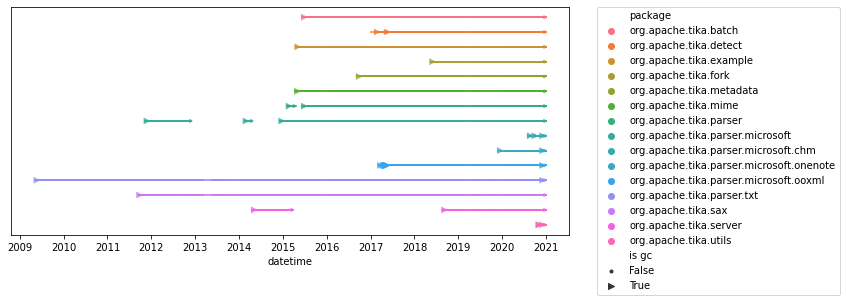

In [543]:
import matplotlib.dates as md
fig, ax = plt.subplots(figsize=(10, 4.2))
# scatter `_` symbols such that it looks like a continuous line.
sns.scatterplot(data=gcdelta[gcdelta['is gc']], x='datetime', y='package', hue='package',\
    ax=ax, legend=False, marker='_', edgecolor=None)
# start- and ending markers for GC lifetime.
sns.scatterplot(data=gcdelta[gcdelta['is gc diff']], x='datetime', y='package', hue='package',\
    ax=ax, edgecolor=None, markers={False: '.', True: '>'},
    style='is gc', alpha=0.75)
ax.xaxis.set_major_locator(md.YearLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))
ax.axes.yaxis.set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Save a small version of `is gc` metric the `# classes` dataframe only where abstract difference > 3

In [544]:
gcdelta[gcdelta['# classes diff'].abs() > 3]\
    .sort_values(['package', 'datetime'], ascending=True)\
    .to_csv('output/diffs_nclasses.csv', index=False, 
        columns=['package', '# classes', '# classes diff', 'author', 'datetime', 'jira', 'commit', 'message'],
        float_format='%.f')
gcdelta[gcdelta['is gc diff']]\
    .sort_values(['package', 'datetime'], ascending=True)\
    .to_csv('output/diffs_isgc.csv', index=False, 
        columns=['package', 'is gc', '# classes', '# classes diff', 'author', 'datetime', 'jira', 'commit', 'message'],
        float_format='%.f')

## God Components per Line Of Code (LOC)
God Component growth in terms of Lines Of Code

In [37]:
all_locs['LOC']

0       6638
1       6662
2       6661
3       6663
4       6682
        ... 
4500    4969
4501    4969
4502    4969
4503    4969
4504    4969
Name: LOC, Length: 4505, dtype: int64

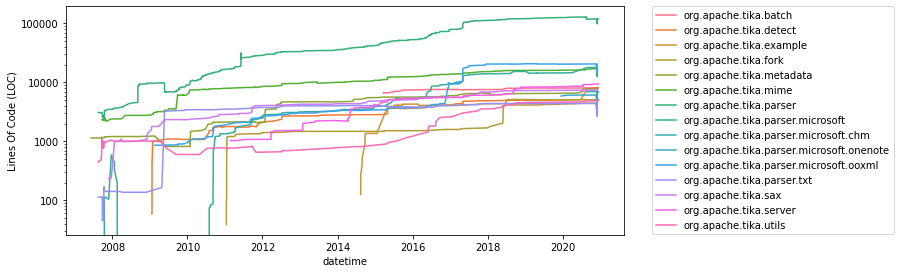

In [38]:
fig, ax = plt.subplots(figsize=(10, 4.2))
g = sns.lineplot(data=all_locs.sort_values('godcomp'), x='datetime', y='LOC', hue='godcomp', ax=ax)
g.set(yscale='log')
g.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ylabel('Lines Of Code (LOC)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Jira Issues analysis

Generally, how many and what types of issues are in Apache Tika's Jira issue tracker?

In [501]:
all_issuetypes = all_issues[['jira', 'issuetype']].drop_duplicates()['issuetype']
print(all_issuetypes.value_counts().sum(), 'issues total.')
all_issuetypes.value_counts()

3248 issues total.


Bug            1592
Improvement    1056
Task            260
New Feature     219
Sub-task         65
Wish             46
Test             10
Name: issuetype, dtype: int64

... of which these amounts are involved in God Component commits:

In [503]:
issuetypes = issuedata[['jira', 'issuetype']].drop_duplicates()['issuetype']
print(issuetypes.value_counts().sum(), 'issues total related to GC commits.')
issuetypes.value_counts()

1694 issues total related to GC commits.


Bug            708
Improvement    643
Task           178
New Feature    107
Sub-task        37
Wish            17
Test             4
Name: issuetype, dtype: int64

... which is this percentage:

In [498]:
issuetypes.value_counts() / all_issuetypes.value_counts()

Bug            0.444724
Improvement    0.608902
Task           0.684615
New Feature    0.488584
Sub-task       0.569231
Wish           0.369565
Test           0.400000
Name: issuetype, dtype: float64

We can also check what issue types are represented most in the God Component commits:

In [504]:
issuetypes.value_counts(normalize=True)

Bug            0.417946
Improvement    0.379575
Task           0.105077
New Feature    0.063164
Sub-task       0.021842
Wish           0.010035
Test           0.002361
Name: issuetype, dtype: float64

Build a pivot table and show heatmap.

In [464]:
def map_gc_issuetype(df):
    value_counts = df['issuetype'].value_counts()

    return pd.DataFrame({
        'count': value_counts.values,
        'issuetype': value_counts.index.categories.values
    })
typecount = issuedata\
    .groupby('package')\
    .apply(map_gc_issuetype)\
    .reset_index(level=0)
typecount

package  count    issuetype
0   org.apache.tika.batch    504          Bug
1   org.apache.tika.batch    502  Improvement
2   org.apache.tika.batch    259  New Feature
3   org.apache.tika.batch     79     Sub-task
4   org.apache.tika.batch     58         Task
..                    ...    ...          ...
2   org.apache.tika.utils      9  New Feature
3   org.apache.tika.utils      1     Sub-task
4   org.apache.tika.utils      0         Task
5   org.apache.tika.utils      0         Test
6   org.apache.tika.utils      0         Wish

[105 rows x 3 columns]

Text(0.5, 1.0, 'Amount of commits related to issue types per GC')

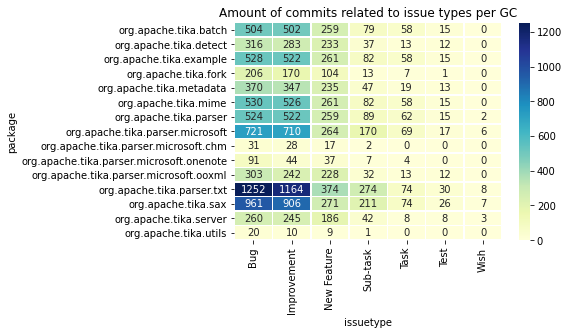

In [460]:
rectangular = typecount.pivot(index='package', columns='issuetype', values='count')
f, ax = plt.subplots()
plt.yticks(rotation=0)
plt.xticks(rotation=45)
g = sns.heatmap(rectangular,\
    annot=True, fmt='d', linewidths=.5,\
    cmap="YlGnBu", yticklabels=True, ax=ax)
plt.title('Amount of commits related to issue types per GC')

### Issue types that contribute to GC buildup
This time around, only include those commits that actually 'build up' a God Component; i.e. those commits that: add classes to a GC.

In [546]:
gcbuildup = gcdelta[gcdelta['# classes diff'] > 0]
gcbuildup = gcbuildup.merge(all_issues, on='jira')
gcbuildup.head()

package                                    commit  \
0   org.apache.tika.batch  30c3d8104a51f015416382995435a4785059f07c   
1  org.apache.tika.detect  8b82b4c942c82f9cc2eb393e669227606b5f15fc   
2   org.apache.tika.utils  8b82b4c942c82f9cc2eb393e669227606b5f15fc   
3  org.apache.tika.detect  a43784b19f6b0955478dded71521b0491d21c90b   
4    org.apache.tika.mime  a43784b19f6b0955478dded71521b0491d21c90b   

   # classes    author                email                   datetime  \
0       32.0  TALLISON  tallison@apache.org  2018-11-13 14:08:26-05:00   
1       37.0  tallison  tallison@apache.org  2020-12-04 13:16:28-05:00   
2       32.0  tallison  tallison@apache.org  2020-12-04 13:16:28-05:00   
3       36.0  tallison  tallison@apache.org  2020-12-02 11:58:44-05:00   
4       35.0  tallison  tallison@apache.org  2020-12-02 11:58:44-05:00   

                                             message       jira  is gc  \
0  TIKA-2778 -- the shutdown method for tika-batc...  TIKA-2778   True   
1  TIKA-3218 -- fix service loading sort order, a...  TIKA-3218   True   
2  TIKA-3218 -- fix service loading sort order, a...  TIKA-3218   True   
3  TIKA-3241 -- fix git add problems, replace som...  TIKA-3241   True   
4  TIKA-3241 -- fix git add problems, replace som...  TIKA-3241   True   

  is gc diff  # classes diff issuetype  
0      False               1      Task  
1      False               1       Bug  
2      False               1       Bug  
3      False               1      Task  
4      False               1      Task

Compute the total amount of classes each issue added

In [550]:
buildup_per_issuetype = gcbuildup.groupby(['issuetype'])\
    .agg({'# classes diff': 'sum'})\
    .reset_index()
buildup_per_issuetype

issuetype  # classes diff
0          Bug              48
1  Improvement             143
2  New Feature              24
3     Sub-task               4
4         Task              56
5         Test               0
6         Wish               0

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Bug'),
  Text(1, 0, 'Improvement'),
  Text(2, 0, 'New Feature'),
  Text(3, 0, 'Sub-task'),
  Text(4, 0, 'Task'),
  Text(5, 0, 'Test'),
  Text(6, 0, 'Wish')])

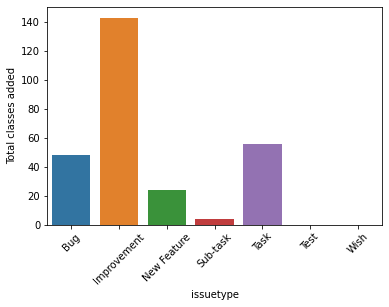

In [560]:
sns.barplot(data=buildup_per_issuetype,
    x='issuetype', y='# classes diff')
plt.ylabel('Total classes added')
plt.xticks(rotation=45)